# Training a Deep Neural Network with Time Series Data

In [1]:
#import paskages 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def plot_series(time, series, format="-", start=0, end=None):

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):


    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)
    return data_pattern

def noise(time, noise_level=1, seed=None):

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

### Generate the Synthetic Data

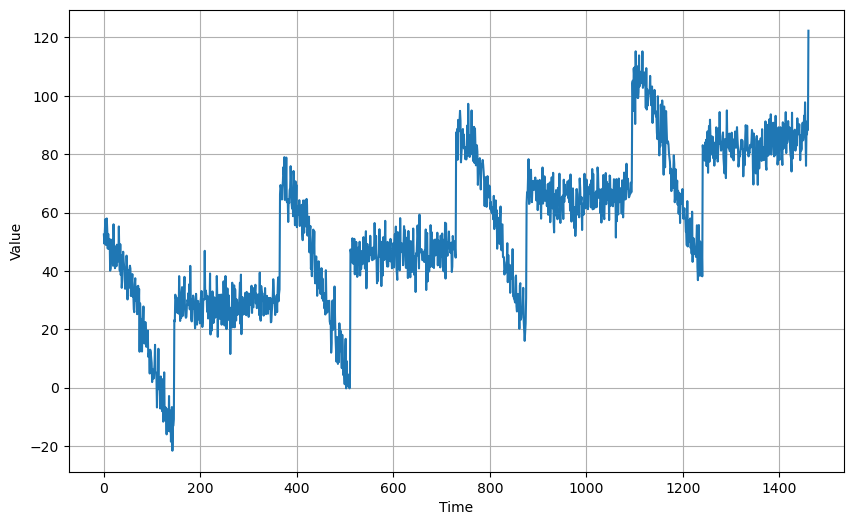

In [5]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

### Split the Dataset

In [6]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

### Prepare Features and Labels

In [7]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [9]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

### Build the Model

You will use three dense layers

In [10]:
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train the Model

In [12]:
model_baseline.compile(loss="mse", 
                       optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,
                                                         momentum=0.9))

In [13]:
# Train the model
model_baseline.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 1303.7050
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 72.6461
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 64.2940
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 63.7799
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 62.4166
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 61.7941
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 61.0660
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 60.2130
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 59.6508
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 58.8382
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 58.1406
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 57.6376
Epoch 13/100
31/31 [===

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


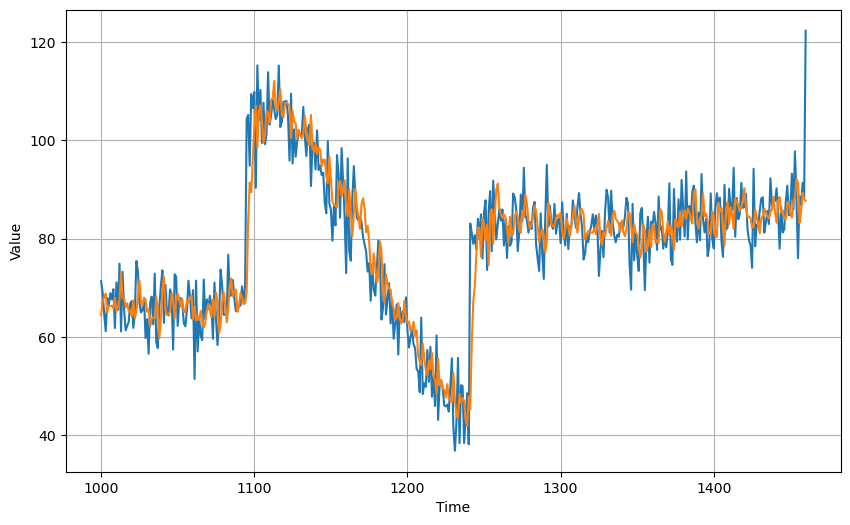

In [15]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [16]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

46.141975
5.055428


### Tune the learning rate

In [17]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [18]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [19]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

In [20]:
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 1524.2717 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 1257.0188 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 986.9909 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 750.6248 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 548.9714 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 391.0475 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 271.8624 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 192.9644 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 144.9629 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 119.7026 - lr: 2.8184e-08
Epoch 1

31/31 [==============================] - 0s 2ms/step - loss: 419.6306 - lr: 1.2589e-04
Epoch 84/100
31/31 [==============================] - 0s 2ms/step - loss: 8699844415717376.0000 - lr: 1.4125e-04
Epoch 85/100
31/31 [==============================] - 0s 2ms/step - loss: 55087415296.0000 - lr: 1.5849e-04
Epoch 86/100
31/31 [==============================] - 0s 1ms/step - loss: 49027670016.0000 - lr: 1.7783e-04
Epoch 87/100
31/31 [==============================] - 0s 2ms/step - loss: 38998155264.0000 - lr: 1.9953e-04
Epoch 88/100
31/31 [==============================] - 0s 2ms/step - loss: 29996843008.0000 - lr: 2.2387e-04
Epoch 89/100
31/31 [==============================] - 0s 2ms/step - loss: 22310455296.0000 - lr: 2.5119e-04
Epoch 90/100
31/31 [==============================] - 0s 2ms/step - loss: 15976529920.0000 - lr: 2.8184e-04
Epoch 91/100
31/31 [==============================] - 0s 1ms/step - loss: 10959057920.0000 - lr: 3.1623e-04
Epoch 92/100
31/31 [========================

(1e-08, 0.001, 0.0, 300.0)

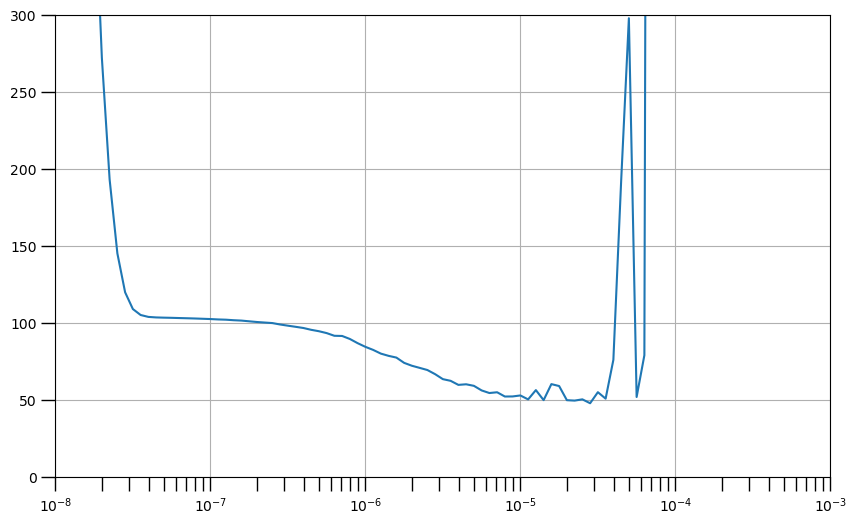

In [21]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

In [22]:
# Build the model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [23]:
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)

In [24]:
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 667.5187
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 113.8720
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 90.6222
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 78.2002
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 65.6810
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 60.2535
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 59.6373
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 55.6264
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 57.3020
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 53.2008
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 53.5521
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 52.4827
Epoch 13/100
31/31 [===

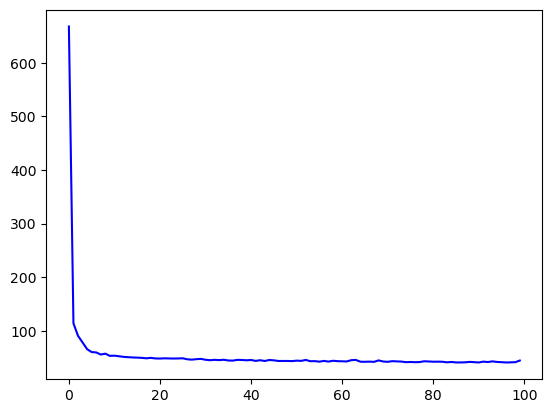

In [25]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

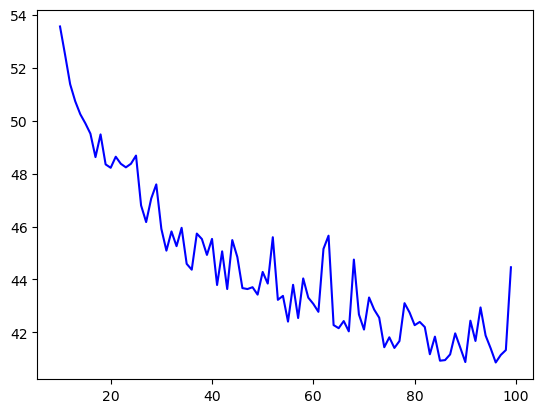

In [26]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()